Gradient descent is used for obtaining the parameters associated with each input vairable in machine learning algorithms (a tutorial [here](https://github.com/wei-ann-Github/Tutorial/blob/myBranch/01%20Linear%20Regression%2C%20Logisitic%20Regression%20and%20Clustering/Linear%20Regression%20-%20Final%20V2%20.ipynb)). When there are millions of parameters, such as in deep learning, if every parameter have the same learrning rate, it can take a long time for the parameters to converge as different parameters will have different gradient scales. Take the eliptical error surface below, the gradient along the green axis is gentler than that along the red axis. When the gradients are multiplied by the same learning rate to update the parameters, the magnitude of the update along the green axis is going to be smaller than the red. Reaching the minimum along the green axis is going to take longer than the red axis.

<img src='http://i.imgur.com/nMp5MOD.png'/>

_<div align="center">Each contour line in the sketch above joins points in the error surface where the error magnitude is the same.</div>_

Damping the gradient and adopting adaptive learning rates are 2 strategies to speed up gradient descent. These 2 strategies are demonstrated in this post.

 A linear regression model fitted on the **Combined Cycle Power Plant** dataset from [UCI Machine Learning Rpository](http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant) is used to demonstrate these strategies. The dataset consists of 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011). The features are the hourly averages of **Temperature (AT)**, **Ambient Pressure (AP)**, **Relative Humidity (RH)** and **Exhaust Vacuum**. The target variable is the **Electrical Output (PE)**.

# Load Data

In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib inline

fname = 'data\Folds5x2_pp.xlsx' # the file is read from local

df = pd.read_excel(fname)

display(df.head());

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


The results returned by sklearn are obtained by numerical means, hence are the true value of the parameters.

In [2]:
y = np.array(df.PE).flatten()
features = ['AT', 'V', 'AP', 'RH']
# x = np.array(df[features].apply(lambda x: (x - np.mean(x))/np.std(x))) 
x = np.array(df[features])
# the bias term is ignored.

lr = LinearRegression(fit_intercept=False)
lr.fit(x, y)
true_params = lr.coef_

# Gradient Descent - Baseline for Comparing Performance of Different Strategies

Here's an implementation of gradient descent:

In [3]:
def predict(x, params0):
    return x.dot(params0)

def error(y, predictions0):
    return predictions0 - y

def rmse(errors):
    rmse_out = np.sqrt(errors.dot(errors)/errors.shape[0])
    return rmse_out

def gradient(errors, x):
    m = x.shape[0]
    gradients = errors.dot(x) / m
    return gradients
    
def grad_desc(x, y, init_params, iterate=100, alpha=0.01):
    params1 = init_params; counter = 0; rmse_list = []
    # in each iteration
    while counter != iterate:
        # the parameter from the last iteration becomes 
        # the old parameter in this iteration
        params0 = params1 
        # make predictions using parameters.
        predictions0 = predict(x, params0)
        # calculate error
        err0 = error(y, predictions0)
        # calculate RMSE and append into a list
        rmse_list.append(rmse(err0))
        # calculate change in cost with respect to parameters, i.e. the gradients
        gradients = gradient(err0, x)
        # update parameters
        params1 = params0 - alpha * gradients
        # repeat.
        counter += 1
    # return last parameters, and the errors in each iteration.
    return params1, rmse_list

The parameters, according to the implementation above, are:

In [4]:
# Set the initial parameters of the model.
np.random.seed(504)
init_params = np.random.random(x.shape[1])

# Settings for the model.
iterations = 15000; alpha = 0.0000018
params1, rmse_list = grad_desc(x, y, init_params, iterate=iterations, alpha=alpha)
predictions1 = predict(x, params1)
pd.DataFrame([true_params, params1], columns=features, index=['True', 'Gradient Descent'])

,AT,V,AP,RH
True,-1.678056,-0.272647,0.502796,-0.099927
Gradient Descent,-0.261119,-0.913232,0.492466,0.137685


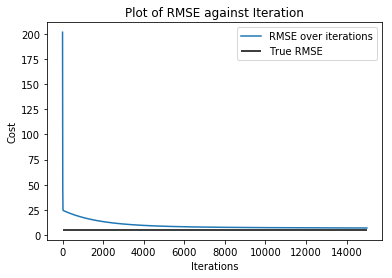

In [5]:
plt.title('Plot of RMSE against Iteration')
plt.plot(range(len(rmse_list)), rmse_list, label='RMSE over iterations')
sklearn_rmse = rmse(error(y, predict(x, true_params)))
plt.hlines(sklearn_rmse, xmin=0, xmax=iterations, label='True RMSE')
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(loc='best')
plt.show()

In the plain implemention of gradient descent, the returned parameters are still some way away from the true parameters given the number of iterations specified. 

Finding the right learning rate (0.000001 in this demonstration) is crucial to ensure that gradient descent is able to converge to a set of optimized parameters. The learning rate at this point is close to the largest learning rate that can be used. When the learning rate is increased by 10%, the cost (rmse) exploded:

D:\Program\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in subtract


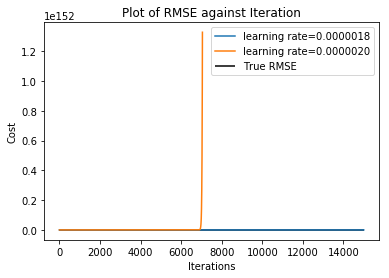

In [6]:
# increase the learning rate, alpha, by 10%
alpha_large = alpha * 1.1
params2, rmse_list2 = grad_desc(x, y, init_params, iterate=iterations, alpha=alpha_large)

plt.title('Plot of RMSE against Iteration')
plt.plot(range(len(rmse_list)), rmse_list, label='learning rate=%.7f' %alpha)
plt.plot(range(len(rmse_list2)), rmse_list2, label='learning rate=%.7f' %alpha_large)
sklearn_rmse = rmse(error(y, predict(x, true_params)))
plt.hlines(sklearn_rmse, xmin=0, xmax=iterations, label='True RMSE')
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(loc='best')
plt.show()

# Strategy 1: Damping the Gradient - Momentum

## Momentum

_Adapted from Lecture 6c (https://www.coursera.org/learn/neural-networks/lecture/Oya9a/the-momentum-method) of Coursera Course, Neural Network for Machine Learning by Geoffrey Hinton (with Nitish Srivastava and Kevin Swersky)._

In physics, momentum is given by Newton's $1^{st}$ law of motion, which states that _every object will remain at rest or in uniform motion in a straight line unless compelled to change it's state_ (it's velocity) _by the action of an external force_. When you catch a basketball thrown at you, you can feel the ball still moving towards you as you catch it. That is the momentum of the ball. Catching the ball applies some force against the motion of the ball, slowing it down.

Momentum, in the physics sense described above, is given by the equation:

$momentum = mv$ 

where $m$ is the mass of an object, and $v$ is the velocity of an object. 

In gradient descent, the concept of momentum has a velocity term, $v$, and a momentum term, $\rho$, introduced (eq 1).

$v_t = \rho v_{t-1} - \alpha \frac{\partial J}{\partial\theta}_{(t)}$---   (1)

$v_t$ depends on $v_{t-1}$ (the velocity in the previous iteration) and $\alpha \frac{\partial J}{\partial \theta}$ (a term we are familiar with in the plain gradient descent method). $\rho$\*\* is the positive momentum term (usually with a value close to 1) and $\alpha$\*\* is the familiar learning rate. 

Instead of updating each parameter, $\theta$, by $\alpha \frac{\partial J}{\partial \theta}$, the parameter is updated by $v_t$:

$$\theta_{t} = \theta_{t-1} + v_{t}-(2)$$

Some intuitions behind the momentum method:

* **The $\rho v_{t-1}$ term is analogous to the momentum of the parameters (the basketball).** 

In the calculations of $v_t$, we see that the velocity, $v_{t-1}$, from the previous iteration is involved. This is as if the new parameter update carries the momentum of the previous iteration.

* **$-\alpha \frac{\partial J}{\partial\theta_{(t)}}$ is analogous to the force applied to "catch" the parameters (the basketball).**

When $-\alpha \frac{\partial J}{\partial\theta_{(t)}}$ has a different sign from $\rho v_{t_1}$, it is acting in the opposite direction of the basketball, opposing it and slowing it down. 

When $-\alpha \frac{\partial J}{\partial\theta_{(t)}}$ has the same sign as $\rho v_{t_1}$, it is acting in the direction of the basketball, giving it extra force to more even faster towards "you", the optimal point (this of course does not happen in real world physics).

\*\*_In Hinton's coursera class, he expressed the momentum term and the learning rate as $\alpha$ and $\epsilon$ respectively. To maintain consistency in this post, I've expressed the momentum term as $\rho$ (in line with physics) and kept the expression for the learning rate as $\alpha$ instead. Other literature may express these 2 terms differently._

In [7]:
def calc_velocity(prev_vel, curr_grad, rho=0.9, alpha=0.1):
    return rho*prev_vel - alpha*curr_grad

def grad_desc_momentum(x, y, init_params, iterate=100, alpha=0.1, rho=0.9):
    params1 = init_params; counter = 0; rmse_list = []
    velocity_1 = np.zeros(x.shape[1])
    # in each iteration
    while counter != iterate:
        # the parameter from the last iteration becomes 
        # the old parameter in this iteration
        # Velocity from the last iterations also becomes
        # the old velocity in this iteration.
        params0 = params1 
        velocity_0, velocity_1 = velocity_1, None
        # make predictions using parameters.
        predictions0 = predict(x, params0)
        # calculate error
        err0 = error(y, predictions0)
        # calculate RMSE and append into a list
        rmse_list.append(rmse(err0))
        # calculate change in cost with respect to parameters, i.e. the gradients
        gradients = gradient(err0, x)
        # adjust rho according to the maximum magnitude of gradients.
        # This is to ensure a small rho while large gradients are still present.
        # as recommended by Geoffery Hinton
        '''My code here.'''
        max_grad = np.max(gradients)
        if max_grad > 10:
            grad_scale = np.log10(max_grad)
        else:
            grad_scale = 1
        if grad_scale > 1.:
            min_rho = max(0.5, rho - (0.5 * (grad_scale - 1.)/grad_scale))
            rho_ = min(rho, min_rho)
        else:
            rho_ = rho
        # update parameters
        # this time with the velocity term
        velocity_1 = calc_velocity(velocity_0, gradients, rho_, alpha)
        params1 = params0 + velocity_1
        # repeat.
        counter += 1
    # return last parameters, and the errors in each iteration.
    return params1, rmse_list

params_momentum, rmse_list_momentum\
 = grad_desc_momentum(x, y, init_params, iterate=iterations, alpha=alpha, rho=0.9)
pd.DataFrame([true_params, params1, params_momentum]
         , columns=features, index=['True', 'Gradient Descent', 'Momentum'])

,AT,V,AP,RH
True,-1.678056,-0.272647,0.502796,-0.099927
Gradient Descent,-0.261119,-0.913232,0.492466,0.137685
Momentum,-1.438184,-0.385313,0.501513,-0.063015


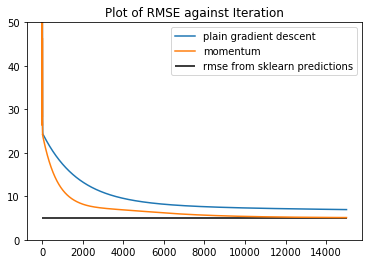

In [8]:
plt.title('Plot of RMSE against Iteration')
# plt.plot(range(len(rmse_list)), rmse_list, label='rmse plain')
# plt.plot(range(len(rmse_list_adapt)), rmse_list_adapt, label='rmse adaptive learning')
plt.plot(range(len(rmse_list)), rmse_list, label='plain gradient descent')
plt.plot(range(len(rmse_list_momentum)), rmse_list_momentum, label='momentum')
sklearn_rmse = rmse(error(y, predict(x, true_params)))
# plt.axis(ymax=rmse_list[0], ymin=454.3)
plt.hlines(sklearn_rmse, xmin=0, xmax=iterations, label='rmse from sklearn predictions')
plt.legend(loc='best')
plt.axis(ymax=50, ymin=0)
plt.show()

The momentum method is able to achieve optimality faster than the plain implementation of gradient descent. 

A faster learning rate can also be used with the momentum method, increasing the speed of the algorithm.

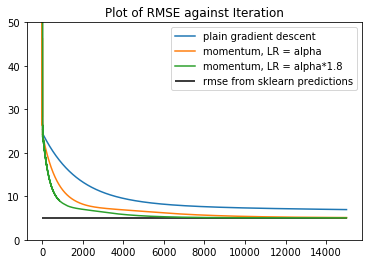

In [9]:
params_momentum2, rmse_list_momentum2\
 = grad_desc_momentum(x, y, init_params, iterate=iterations, alpha=alpha*1.8, rho=0.9)
pd.DataFrame([true_params, params1, params_momentum, params_momentum2]
         , columns=features, index=['True', 'Gradient Descent', 'Momentum', 'Momentum, larger learning rate'])

plt.title('Plot of RMSE against Iteration')
# plt.plot(range(len(rmse_list)), rmse_list, label='rmse plain')
# plt.plot(range(len(rmse_list_adapt)), rmse_list_adapt, label='rmse adaptive learning')
plt.plot(range(len(rmse_list)), rmse_list, label='plain gradient descent')
plt.plot(range(len(rmse_list_momentum)), rmse_list_momentum, label='momentum, LR = alpha')
plt.plot(range(len(rmse_list_momentum2)), rmse_list_momentum2, label='momentum, LR = alpha*1.8')
sklearn_rmse = rmse(error(y, predict(x, true_params)))
# plt.axis(ymax=rmse_list[0], ymin=454.3)
plt.hlines(sklearn_rmse, xmin=0, xmax=iterations, label='rmse from sklearn predictions')
plt.legend(loc='best')
plt.ylim((0, 50))
plt.show()

Still, eventually the gradients will increase without bounds when the learning rate is too fast.

# Strategy 2: The Adpative Learning Rate - Gain and Rprop

## Gain

_Adapted from Lecture 6d (https://www.coursera.org/learn/neural-networks/lecture/NHxnS/adaptive-learning-rates-for-each-connection) of Coursera Course, Neural Network for Machine Learning by Geoffrey Hinton (with Nitish Srivastava and Kevin Swersky)._

In adaptive learning rate, gain, g, is introduced. Gain introduces an multiplicative factor for each parameter to adjust the learning rate:

$\theta_i = \theta_i - \alpha * g_i * \frac{\partial J}{\partial \theta_i}$

where: 

* $J$ is the cost function.
* $\theta_i$ represents parameter i.
* $\frac{\partial J}{\partial \theta_i}$ is the partial differentiation of the cost function with respect to $\theta_i$, i.e. the gradient at $\theta_i$.
* $\alpha$ is the learning rate.
* $g_i$ is the gain of parameter i.

Gain starts at 1 for all parameters, and changes according to 2 simple rules:

* If $\frac{\partial J}{\partial \theta_i}$ in the current iteration has the same sign as $\frac{\partial J}{\partial \theta_i}$ in the previous iteration, add a small number, e.g. 0.05, to gain. The effective learning rate for that parameter is increased since the parameter has not crossed the minimum point and land on the other side of the curve.
* If $\frac{\partial J}{\partial \theta_i}$ in the current iteration has a different sign from $\frac{\partial J}{\partial \theta_i}$ in the previous iteration, multiply the gain by 1 minus a small number e.g. (1 - 0.05). The effective learning rate for that parameter is reduced since the gain is reduced to a fraction of what it once was.

In [10]:
def adaptive_learning(grad_prev, grad0, g, delta=0.05): # let delta be the small number.
    for i, (old, now) in enumerate(zip(grad_prev, grad0)):
        # if the signs of the gradients are the same
        if (old > 0) == (now > 0):
            # increase g[i] by delta
            g[i] += delta
        # else the signs of the gradients are different.
        else:
            # decrease g[i] by (1 - delta) %
            g[i] *= (1 - delta)

In [11]:
def grad_desc2(x, y, init_params, iterate=100, alpha=0.01, delta=0.05):
    params1 = init_params; counter = 0; rmse_list = []
    g = np.ones(x.shape[1]) # g is the gain
    # in each iteration
    while counter < iterate:
        # the parameter from the last iteration becomes 
        # the old parameter in this iteration
        params0 = params1 
        # make predictions using parameters.
        predictions0 = predict(x, params0)
        # calculate error
        err0 = error(y, predictions0)
        # calculate RMSE and append into a list
        rmse_list.append(rmse(err0))
        # calculate change in cost with respect to parameters, i.e. the gradients
        gradients = gradient(err0, x)
        
        # what is the sign of he current gradient compared to the previous gradients?
        # adjust the learning rate.
        try:
            adaptive_learning(grad_prev, gradients, g, delta=delta)
        except:
            pass
        
        # update parameters
        params1 = params0 - alpha * g * gradients
        
        # prepare for the next iteration
        counter += 1
        grad_prev = gradients
        
    # return last parameters, and the errors in each iteration.
    return params1, rmse_list, g

# reduce the number of iterations as well.
iterations2 = int(0.25*iterations)
params_adapt, rmse_list_adapt, gain = grad_desc2(x, y, init_params, iterate=iterations2, alpha=alpha)
pd.DataFrame([true_params, params1, params_momentum, params_adapt]
         , columns=features, index=['True', 'Gradient Descent', 'Momentum', 'Adaptive Learning'])

,AT,V,AP,RH
True,-1.678056,-0.272647,0.502796,-0.099927
Gradient Descent,-0.261119,-0.913232,0.492466,0.137685
Momentum,-1.438184,-0.385313,0.501513,-0.063015
Adaptive Learning,-1.661593,-0.280470,0.502681,-0.096976


The adpative learning rate is able to learn a set of parameters that are closer to the true parameters.

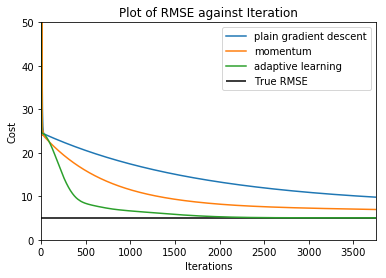

In [12]:
plt.title('Plot of RMSE against Iteration')
plt.plot(range(len(rmse_list)), rmse_list, label='plain gradient descent')
plt.plot(range(len(rmse_list_momentum)), rmse_list_momentum, label='momentum')
plt.plot(range(len(rmse_list_adapt)), rmse_list_adapt, label='adaptive learning')
sklearn_rmse = rmse(error(y, predict(x, true_params)))
plt.hlines(sklearn_rmse, xmin=0, xmax=iterations, label='True RMSE')
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(loc='best')
plt.xlim([0, iterations2])
plt.ylim([0, 50])
plt.show()

Just over 2000 iterations for the parameters to converge.

Here are the gain of each parameters.

In [13]:
# inspect gain.
gain

array([ 187.7983373 ,   82.50709166,    0.61712146,   42.29823577])

Inspection of gain shows that it is more than 1 for AT, V and RH, and less than 1 for AP. From the plain implementation of gradient descent, these 3 variables have parameters which deviate furthest away from the true values. This shows that AT, V and RH have relatively gentle slopes, hence it takes a longer time to converge using plain gradient descent. Using adaptive learning, the parameters converge in a smaller number of iterations.

## Rprop

_Adapted from Lecture 6e (https://www.coursera.org/learn/neural-networks/lecture/YQHki/rmsprop-divide-the-gradient-by-a-running-average-of-its-recent-magnitude) of Coursera Course, Neural Network for Machine Learning by Geoffrey Hinton (with Nitish Srivastava and Kevin Swersky)._

_A paper with the implementation detail can be found [here](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=F65830196E60C686128898ECD61205ED?doi=10.1.1.21.3428&rep=rep1&type=pdf)*._

Rprop (Resilient backpropagation) is similar to gain in that the signs of the current gradient and of the previous gradient are compared to decide on how to update the parameters. Rprop, however, deviates from what we have seen of far about gradient descent in that it does not rely on the value of the gradients to change the weights. It relies only on the sign of the gradient. The parameters are updated only "by a weight-specific, so-called 'update-value' $\vartriangle_{ij}^{(t)}$" (Riedmiller, 1994). Think of $\vartriangle_{ij}^{(t)}$ as $\alpha*g$.

When the signs of the gradients in the current iteration is different from the signs in the previous iteration, the optimal parameter value has already been "stepped over", hence we need to back track. The update-value is thus decreased by 0.5. If the gradients are the same, we can increase the update value by multiplying by 1.("Slight variations of this value did neither improve nor deterioate convergence time", Riedmiller). 

* Gradients of the same sign $\rightarrow$ update value, $\vartriangle_{ij}(t) = \vartriangle_{ij}(t-1) * 1.2$
* Gradients of different signs $\rightarrow$ update value, $\vartriangle_{ij}(t) = \vartriangle_{ij}(t-1) * 0.5$

And the parameters are updated by $-sign(\frac{\partial E}{\partial w_{ij}}(t)) *\vartriangle_{ij}(t)$

A recommendation, made in the implementation detail, is limiting the update value, $\vartriangle_{ij}(t)$, to between $1*10^{-6}$ and $50.0$.

\*Riedmiller, Martin,. January 1994. _Rprop - Description and Implementation Details_. Technical Report. http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=F65830196E60C686128898ECD61205ED?doi=10.1.1.21.3428&rep=rep1&type=pdf

In [14]:
def rprop(params, grad_prev, grad0, update_vals, same_sign=1.2, diff_sign=0.5, update_max=50.0, update_min=10.0**-6):
    for i, (old, now) in enumerate(zip(grad_prev, grad0)):
        # if the signs of the gradients are the same
        if old*now > 0 :
            # increase the update_vals
            update_vals[i] = min(update_vals[i]*same_sign, update_max)
            # parameter chnage = sign of the current gradient * the update value
            param_change = - (now/abs(now))*update_vals[i]
            params[i] += param_change
            grad_prev[i] = grad0[i]
        # else the signs of the gradients are different or equilibrium reached.
        else:
            if old*now < 0:
                update_vals[i] = max(update_vals[i]*diff_sign, update_min)
                grad_prev[i] = 0 # if the gradients have different signs, the
                                # parameter is only updated in the next iteration.
            elif old*now == 0:
                param_change = -(now/abs(now))*update_vals[i]
                params[i] += param_change
                grad_prev[i] = grad0[i]
    return params, grad_prev, update_vals;

In [15]:
def grad_desc3(x, y, init_params, update_vals, iterate=100, **kwargs):
    params1 = init_params.copy(); counter = 0; rmse_list = []; grad_prev = np.zeros(params1.shape);
#     factor = np.ones(x.shape[1]) # something different from rprop
    assert len(update_vals) == len(init_params), 'The length of updates_vals \
    and the length of init_paramters does not match';
    # in each iteration
    while counter < iterate:
        # the parameter from the last iteration becomes 
        # the old parameter in this iteration
        params0 = params1 
        # make predictions using parameters.
        predictions0 = predict(x, params0)
        # calculate error
        err0 = error(y, predictions0)
        # calculate RMSE and append into a list
        rmse_list.append(rmse(err0))
        # calculate change in cost with respect to parameters, i.e. the gradients
        gradients = gradient(err0, x)

        params1, grad_prev, update_vals = rprop(params0, grad_prev, gradients, update_vals, **kwargs);
                
        # update parameters is performed in the rprop function
        
        # prepare for the next iteration
        counter += 1
        
    # return last parameters, and the errors in each iteration.
    return params1, rmse_list, update_vals;

update_vals = np.ones(init_params.shape) * 0.1 ; # initialize the update value to the default value in (Martin, 1994).
params_rprop, rmse_list_rprop, update_vals = grad_desc3(x, y, init_params, update_vals, iterate=iterations2)
pd.DataFrame([true_params, params1, params_momentum, params_adapt, params_rprop]
             , columns=features, index=['True', 'Gradient Descent', 'Momentum', 'Adaptive Learning', 'rprop'])

,AT,V,AP,RH
True,-1.678056,-0.272647,0.502796,-0.099927
Gradient Descent,-0.261119,-0.913232,0.492466,0.137685
Momentum,-1.438184,-0.385313,0.501513,-0.063015
Adaptive Learning,-1.661593,-0.280470,0.502681,-0.096976
rprop,-1.679970,-0.271547,0.502784,-0.100072


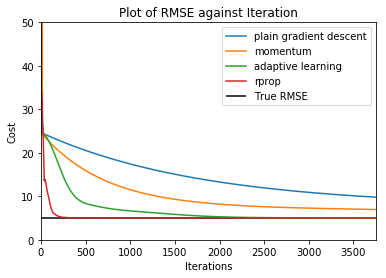

In [16]:
plt.title('Plot of RMSE against Iteration')
plt.plot(range(len(rmse_list)), rmse_list, label='plain gradient descent')
plt.plot(range(len(rmse_list_momentum)), rmse_list_momentum, label='momentum')
plt.plot(range(len(rmse_list_adapt)), rmse_list_adapt, label='adaptive learning')
plt.plot(range(len(rmse_list_rprop)), rmse_list_rprop, label='rprop')
sklearn_rmse = rmse(error(y, predict(x, true_params)))
plt.hlines(sklearn_rmse, xmin=0, xmax=iterations, label='True RMSE')
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(loc='best')
plt.xlim([0, iterations2])
plt.ylim([0, 50])
plt.show()

The performance of rprop is even better than adaptive learning. 

Advantages of rprop: 

* it is not affected by the [vanishing graident](https://www.quora.com/What-is-the-vanishing-gradient-problem) problem as it does not relying on the value of the gradient to update the parameters. 
* Concerns about choosing the learning rate is gone as well since it is not used. 

Disadvantages of rprop: 

* Since the change in the update values are fixed, rprop may face some issue when the input is scaled incorrectly. 
* Rprop is not suitable for batch learning (Hinton). For batch learning, RMSProp, an adaptation of rprop, can be used instead. RMSProp will not be discussed in this post.

# Final Note

The limitations of plain gradient descent may not be apparent when applied to "normal" machine learning algorithms. When applied to deep learning, however, its limitations show as there are many more parameters to learn (in the millions!), and parameters affect one another in a multiplicative way as the signals propagate from one layer to the next. Each parameter may require learning rate of different scale, or the same learning rate can be ineffective in latter part of the learning process due to issues like the vanish gradient problem. This has led to the different improvisations to gradient descent. This post only  highlighted 3 such adaptations for full batch learning. 

**Note**

When it comes to batch learning, a different set of challenges for gradient descent is present, and hence different improvisations are needed.